In [1]:
import sys
import os

# Assuming notebooks and src are subdirectories of the project directory
parent_dir = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
sys.path.append(os.path.join(parent_dir, 'src'))

In [2]:
import torch

import logitlens
import utils
import viz
import cluster

/u/jdr/venvs/venv_lexcons/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


### Initial look at what this gap looks like

In [3]:
L = utils.load_noun_pair_data() 
L_train, L_test = utils.split_train_test(L, seed=0, subsample=False, num_train=3000)

disc_base = torch.load('../outputs/logodds/gemma-2-2b--disc-few.pt', weights_only=True)
gen_base = torch.load('../outputs/logodds/gemma-2-2b--gen-zero.pt', weights_only=True)

Pearson:  0.780615670302538
Pearson for pos:  0.5381100052854741
Pearson for neg:  0.4742380154859837


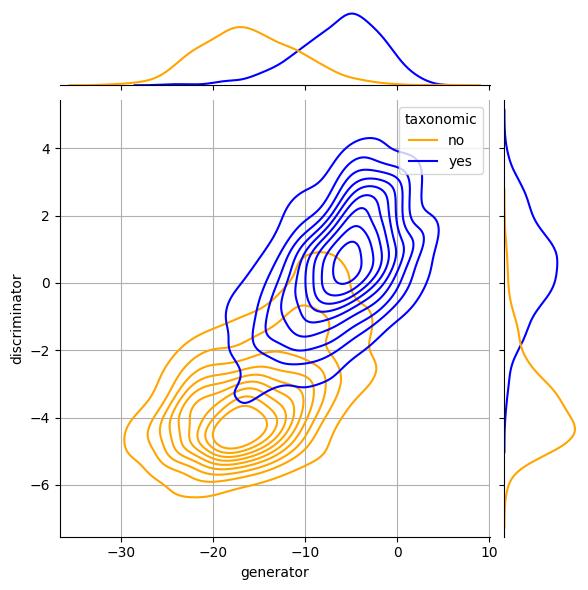

In [4]:
viz.plot_correlations(L_test, gen_base, disc_base)

### Do generator logodds correlate with rank?

In [13]:
import json
import numpy as np
gen_pos = torch.load('../outputs/logodds/ftmodel--gemma-2-2b--generator--zero--pos--gen-zero.pt', weights_only=True)
with open('../outputs/logodds/ftmodel--gemma-2-2b--generator--zero--pos--gen-zero--ranks.json', 'r') as fd:
    gen_pos_ranks = json.load(fd)
neglogrank = -np.log(gen_pos_ranks)

Pearson correlation:  0.8956719011046267


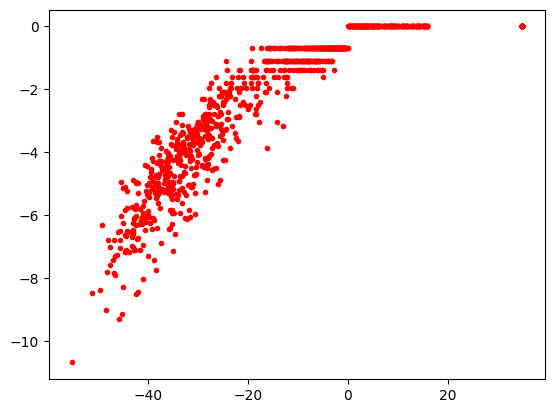

In [19]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
last_layer_logprobs = [i[-1] for i in gen_pos]
plt.plot(last_layer_logprobs, neglogrank, 'r.')

print("Pearson correlation: ", pearsonr(last_layer_logprobs, neglogrank).statistic)


### Do models exposed to generator/discriminator views of the *same* data have a smaller gap?

In [22]:
gen = torch.load('../outputs/logodds/ftmodel--gemma-2-2b--generator--zero--all--negation--gen-zero.pt', weights_only=True)
disc = torch.load('../outputs/logodds/ftmodel--gemma-2-2b--discriminator--few--all--disc-few.pt', weights_only=True) 

Pearson:  0.8366523903310914
Pearson for pos:  0.3347088974260942
Pearson for neg:  0.45627028674636877


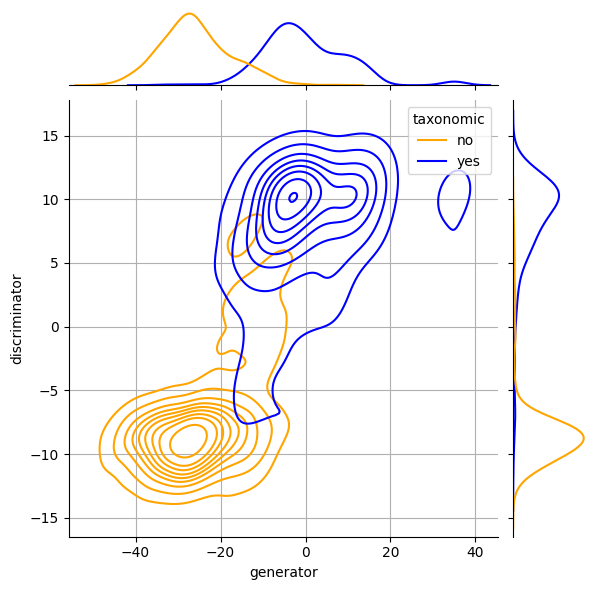

In [23]:
viz.plot_correlations(L_test, gen, disc)

## Example visualizing argmax words over layers and positions 

In [28]:
import huggingface_hub
huggingface_hub.login()

In [34]:
model = logitlens.load_model_nnsight("openai-community/gpt2-xl", "cuda:0")

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


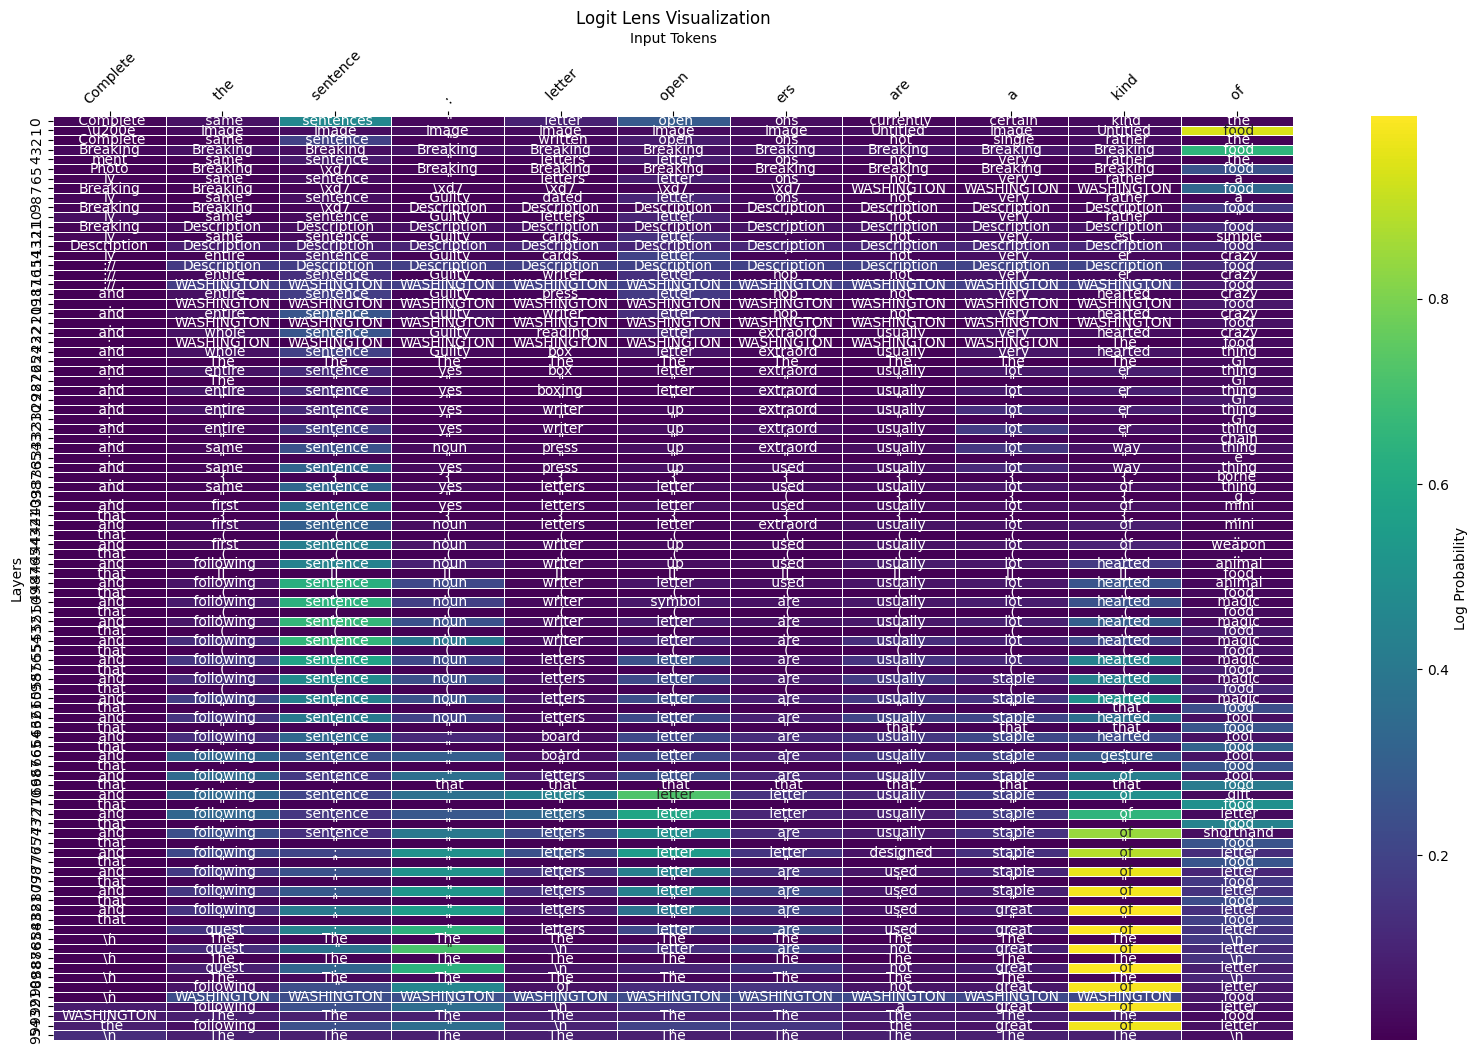

In [35]:
prompt = utils.make_prompt(L_test[0], style="generator", shots="zero", neg=False)
probs, max_probs, tokens, words, input_words = logitlens.get_logitlens_output(prompt, model, "gpt2-xl")
viz.logitlens_viz(words, input_words, max_probs, savename=None)

### Example visualizing log-odds over layers at the last position

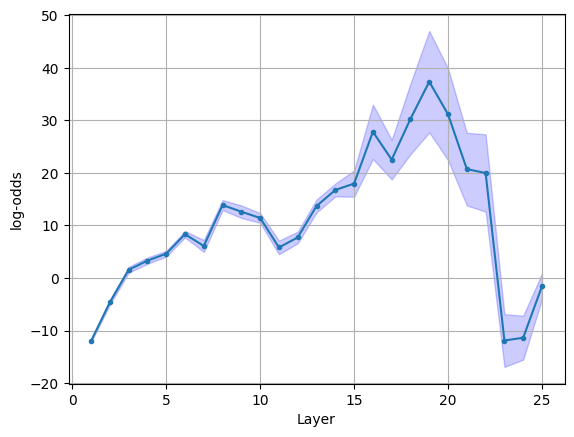

In [38]:
# For the generator, notice most example follow a similar trend (very likely to say Yes, then drops down to No, 
# and finally settles to a more sensible value at the last layer.
viz.plot_logodds_over_layers(disc_base)

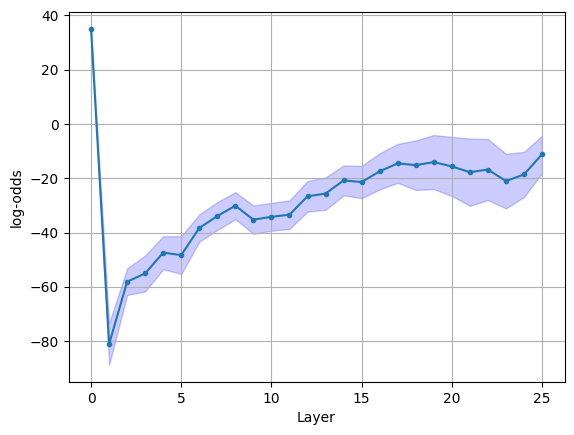

In [40]:
## Now the generator
viz.plot_logodds_over_layers(gen_base)

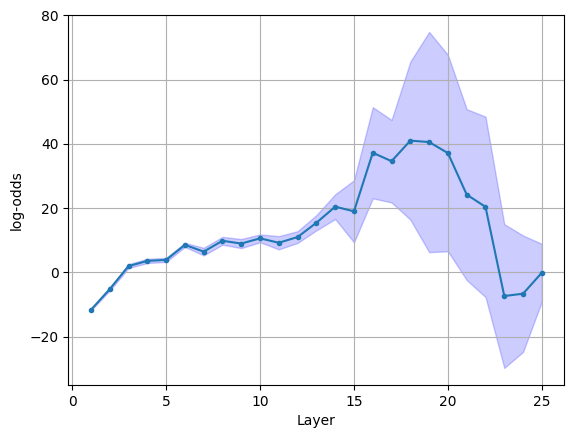

In [43]:
## What happened after fine-tuning?

# Discriminator:
viz.plot_logodds_over_layers(disc)

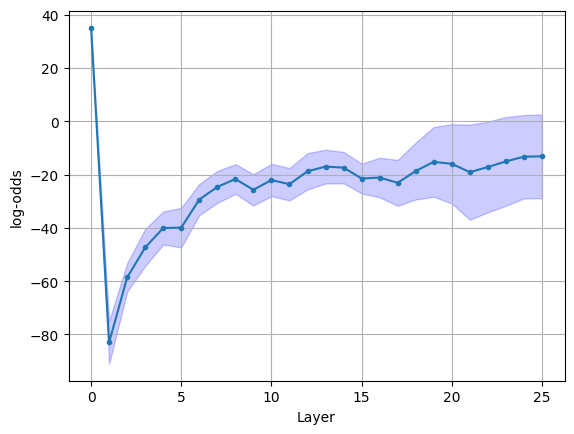

In [44]:
# Generator:
viz.plot_logodds_over_layers(gen)

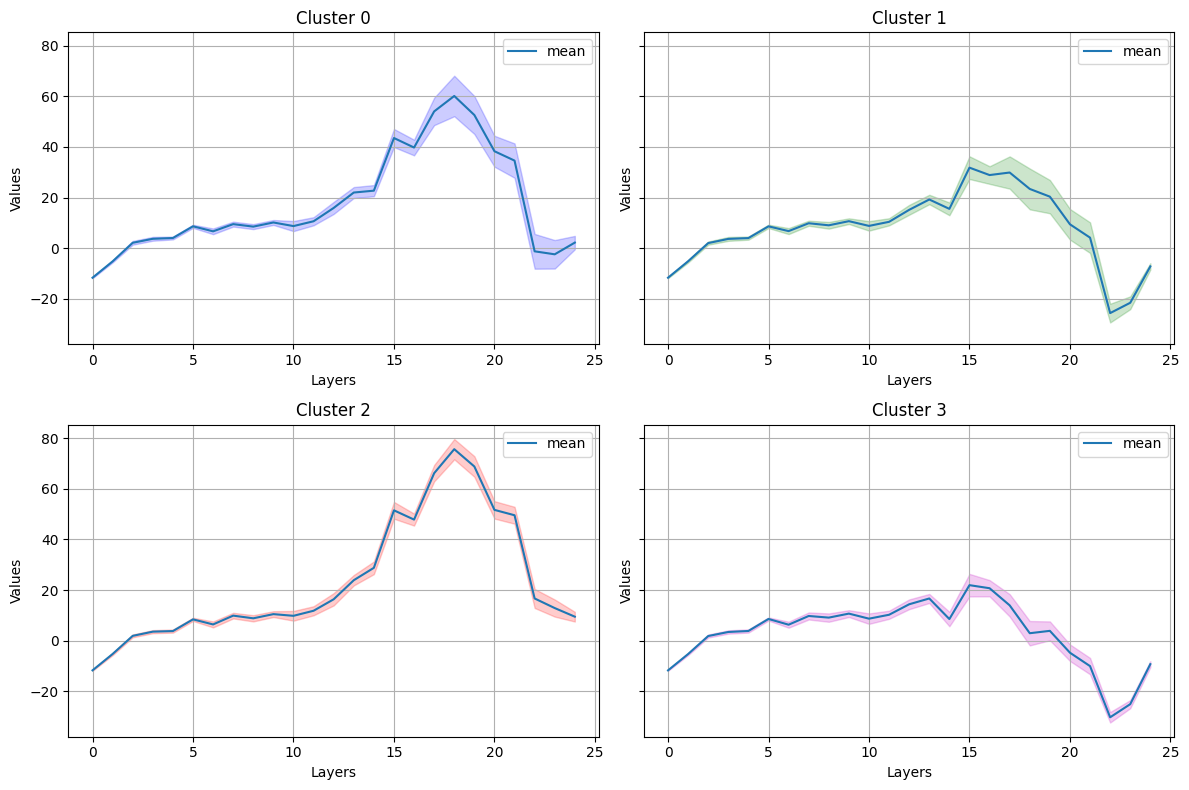

In [56]:
# The standard deviations are wide, so this is not so informative.
# Will cluster to see what kind of patterns we see:

labels = cluster.cluster([i[1:] for i in disc], num_clusters=4, smooth_window_size=1, norm_by_max=False)

In [59]:
from collections import Counter
Counter(labels)

Counter({np.int32(2): 433, np.int32(3): 408, np.int32(1): 90, np.int32(0): 87})